# GLORYs Bias Corrections

I don't want to deal with creating and saving date keys just to do the bais corrections in R again. We can skip that organizational hurdle by keeping things in python.

This notebook will handle the following things:

 * Load data from our suite of CMIP models, matching historical periods to projections
 * Build climatologies for each for a reference period which we can match with GLORYS
 * Determine seasonal biases (deltas) between CMIP models and the GLORYs climatology
 * Use monthly/seasonal deltas to bias-correct CMIP model monthly/seasonal anomalies

In [1]:
import glob             # for file listing
import xarray as xr     # for netcdfs
import numpy as np      # array tools
import fcts             # local functions
import xmip             # common preprocessing for cmip6 data
import xesmf as xe      # irregular grid support and interpolation methods
import dask
from matplotlib import pyplot as plt
import os
import cftime

# XMIP preprocessing
from xmip.preprocessing import combined_preprocessing

# Function to help handle irregular grids
from xmip.preprocessing import replace_x_y_nominal_lat_lon


## Pick a CMIP Scenario & Variable to Process

The code chunks below will be set up to process one variable at a time. We have four oiptions stored

In [2]:
# User info for paths to data and for exporting:
UsrName          = 'adamkemberling'
Group            = 'RES_Data'

# Scenario Details
Experiment       = 'ssp585'
Folder           = 'CMIP6/'
ExperimentFolder = 'CMIP6/SSP5_85/'

# Variable Pick - matches glorys data
var_choice = "surf_temp"

# # Set up paths - if fcts works
# CMIPpath = fcts.shared_path(user_name = UsrName, group = Group, folder = Folder)
#ExperimentPath = fcts.shared_path(user_name = UsrName, group = Group, folder = ExperimentFolder)

# Or manually set paths to resources
CMIPpath       = f"/Users/{UsrName}/Library/CloudStorage/Box-Box/RES_Data/{Folder}"
ExperimentPath = f"/Users/{UsrName}/Library/CloudStorage/Box-Box/RES_Data/{ExperimentFolder}"
HistoricalPath = f"/Users/{UsrName}/Library/CloudStorage/Box-Box/RES_Data/{Folder}Historical/"
glorys_path    = f"/Users/{UsrName}/Library/CloudStorage/Box-Box/RES_Data/GLORYs/NW_Atl_MonthlyTemps/"

# Variable options, these are the variable names in the datasets
var_options = {
    "surf_sal"  : "Surface_so",
    "bot_sal"   : "so",
    "surf_temp" : "tos",
    "bot_temp"  : "thetao"}

# Only needed if we're using glorys_grid_ files
# # Var folders,  for some reason when we regridded we used these directories
# var_folder_key = {
#     "surf_sal"  : "SurSalinity",
#     "bot_sal"   : "BottomSal",
#     "surf_temp" : "SST",
#     "bot_temp"  : "BottomT"
# }

# select the relevant one
cmip_var = var_options[var_choice]
#var_folder = var_folder_key[var_choice]


# Set min/max years for climatology
clim_min = 1993
clim_max = 2023

## List Paths to Historical and Scenario Projection Datasets

These were each downloaded with one variable to limit the filesizes. Historical files are stored+organized together in their own directory. Their filenames contain information on the variables they hold, CMIP6 experiment info, as well as the institution that produced the model. For more details on the naming look here [in this document](https://docs.google.com/document/d/1h0r8RZr_f3-8egBMMh7aqLwy3snpD6_MrDz1q8n5XUk/edit?tab=t.0)

In [3]:
# Paths to Historical datasets that were regridded with cdo tools
hist_ds = glob.glob(f'{HistoricalPath}RawTmpFiles/{cmip_var}*_historical*')
hist_ds[0]

# Paths to scenario datasets that were regridded with cdo tools
scenario_ds = glob.glob(f'{ExperimentPath}RawTmpFiles/{cmip_var}*_{Experiment}*')
scenario_ds[0]


#--------------------
# These look strange/bad/bubbly on a map - not using

# # Paths to Historical Datasets that were just downloaded
# hist_ds = glob.glob(f'{HistoricalPath}{var_folder}/GlorysGrid/GlorysGrid_{cmip_var}*_historical*')
# hist_ds[0]

# # Paths to scenario datasets that were regridded with cdo tools
# scenario_ds = glob.glob(f'{ExperimentPath}{var_folder}/GlorysGrid/GlorysGrid_{cmip_var}*_{Experiment}*')
# scenario_ds[0]

'/Users/adamkemberling/Library/CloudStorage/Box-Box/RES_Data/CMIP6/SSP5_85/RawTmpFiles/tos_NESM3_r1i1p1f1_ssp585.nc'

## Matching+Concatenating Historic and Projection Periods

In [4]:

# Put them each in dictionaries by their experiment info

# Function to extract the common part of the filename
# Function to extract the common part of the filename
def get_common_part(filename, suffix):
    base_name = os.path.basename(filename)  # Get the base name
    base_name = base_name.replace(suffix, "")  # Remove the suffix
    base_name = base_name.replace("GlorysGrid_", "")  # Remove the prefix if we have it
    base_name = base_name.replace("StGrid_", "")  # Remove the prefix if we have it
    return base_name 

# Build a dictionary to store matches
matched_files = {}

# Get common parts from list_1
common_parts_1 = {get_common_part(file, "_historical.nc"): file for file in hist_ds}

# Get common parts from list_2
common_parts_2 = {get_common_part(file, f"_{Experiment}.nc"): file for file in scenario_ds}

# Keep only matches that exist in both lists
for common_part in common_parts_1.keys() & common_parts_2.keys():
    matched_files[common_part] = [common_parts_1[common_part], common_parts_2[common_part]]

len(matched_files)
for id, dataset in matched_files.items():
    print(f"Matches found for: {id}")


Matches found for: tos_EC-Earth3-Veg-LR_r1i1p1f1
Matches found for: tos_MIROC6_r1i1p1f1
Matches found for: tos_NorESM2-LM_r1i1p1f1
Matches found for: tos_EC-Earth3-Veg_r1i1p1f1
Matches found for: tos_IPSL-CM6A-LR_r1i1p1f1
Matches found for: tos_CMCC-CM2-SR5_r1i1p1f1
Matches found for: tos_FGOALS-g3_r1i1p1f1
Matches found for: tos_GISS-E2-1-G_r1i1p3f1
Matches found for: tos_CESM2-WACCM_r1i1p1f1
Matches found for: tos_NESM3_r1i1p1f1
Matches found for: tos_CNRM-ESM2-1_r4i1p1f2
Matches found for: tos_HadGEM3-GC31-LL_r1i1p1f3
Matches found for: tos_MRI-ESM2-0_r1i1p1f1
Matches found for: tos_EC-Earth3_r1i1p1f1
Matches found for: tos_GFDL-CM4_r1i1p1f1
Matches found for: tos_CIESM_r1i1p1f1
Matches found for: tos_INM-CM4-8_r1i1p1f1
Matches found for: tos_CanESM5_r1i1p2f1
Matches found for: tos_FIO-ESM-2-0_r1i1p1f1
Matches found for: tos_CNRM-CM6-1_r1i1p1f2
Matches found for: tos_INM-CM5-0_r1i1p1f1
Matches found for: tos_CanESM5-CanOE_r1i1p2f1
Matches found for: tos_NorESM2-MM_r1i1p1f1
Matches f

## Append historical periods to projections

At this point we can attach the historical periods to scenario projections produced by the same institution and under the same experimental conditions.

For this step, the matched datasets are preprocessed using `xmip`'s preprocessing functions to standardize the cmip6 datasets. These functions help eliminate inconsistencies in coordinate/variable/dimension names and units, and make it easier to work with them in the same pipeline.

For more details and tutorials see [xmip tutorials here](https://github.com/jbusecke/xMIP/blob/main/docs/tutorial.ipynb)


In [5]:
# Match up the projections to the historical periods

# Function to append NetCDF files along the time dimension
def append_netcdf_files(file_pair):
    # Open both files as datasets
    datasets = [xr.open_dataset(file, chunks={"time": 100}) for file in file_pair]

    # Apply xmip preprocessing
    datasets = [combined_preprocessing(ds) for ds in datasets]
    
    # Concatenate along the time dimension
    concatenated = xr.concat(datasets, dim = "time")

    # Close the datasets
    for ds in datasets:
        ds.close()
    return concatenated

# Process all matched files
concatenated_datasets = {}
for key, file_pair in matched_files.items():
    concatenated_datasets[key] = append_netcdf_files(file_pair)


# # Check one
# concatenated_datasets['tos_UKESM1-0-LL_r1i1p1f2']

/Users/adamkemberling/Documents/Repositories/lobSDM/.pixi/envs/default/lib/python3.10/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MIROC.MIROC6.historical.r1i1p1f1.Omon.gn.none.tos:While renaming to target `lon_bounds`, more than one candidate was found ['x_bnds', 'vertices_longitude']. Renaming x_bnds to lon_bounds. Please double check results.
  warnings.warn(
/Users/adamkemberling/Documents/Repositories/lobSDM/.pixi/envs/default/lib/python3.10/site-packages/xmip/preprocessing.py:96: UserWarning: CMIP.MIROC.MIROC6.historical.r1i1p1f1.Omon.gn.none.tos:While renaming to target `lat_bounds`, more than one candidate was found ['y_bnds', 'vertices_latitude']. Renaming y_bnds to lat_bounds. Please double check results.
  warnings.warn(
/Users/adamkemberling/Documents/Repositories/lobSDM/.pixi/envs/default/lib/python3.10/site-packages/xmip/preprocessing.py:96: UserWarning: ScenarioMIP.MIROC.MIROC6.ssp585.r1i1p1f1.Omon.gn.none.tos:While renaming to target `lon_bounds`, more than

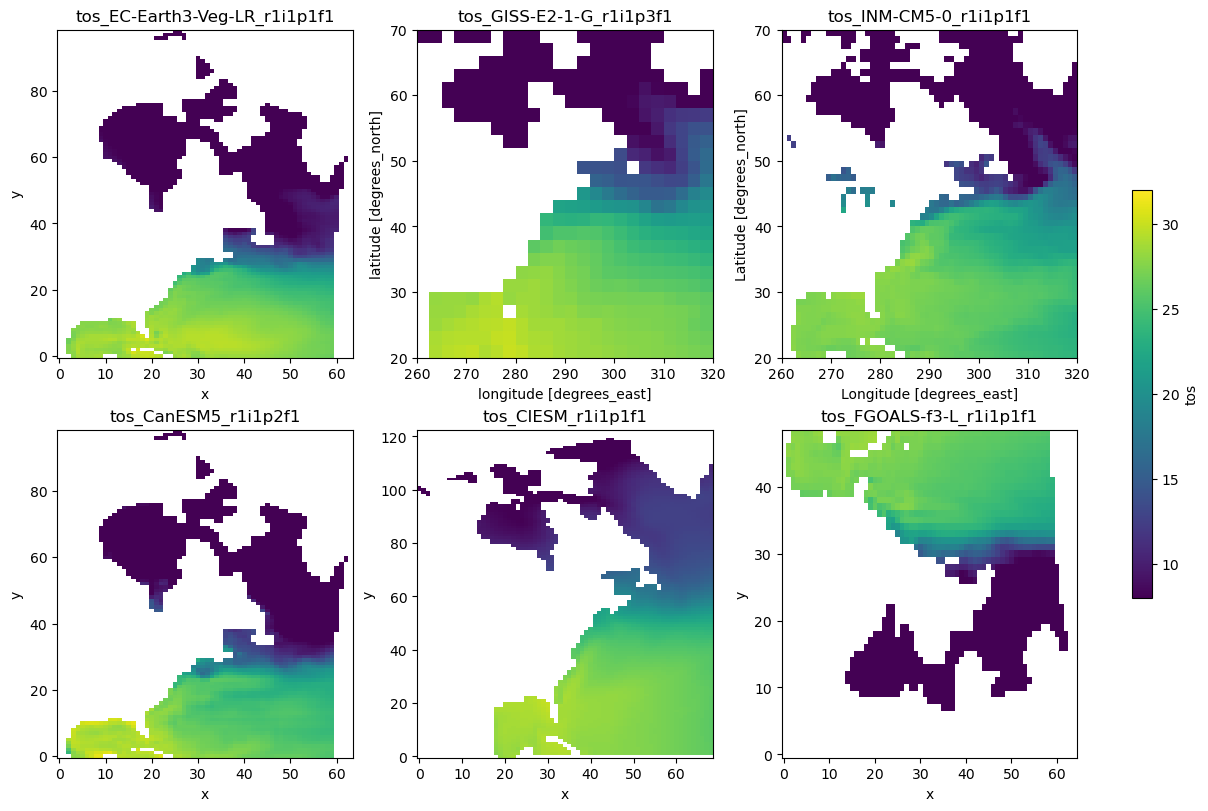

In [6]:
# Select datasets to plot
keys_to_plot = [
    "tos_EC-Earth3-Veg-LR_r1i1p1f1", "tos_GISS-E2-1-G_r1i1p3f1", "tos_INM-CM5-0_r1i1p1f1", 
    "tos_CanESM5_r1i1p2f1", "tos_CIESM_r1i1p1f1", "tos_FGOALS-f3-L_r1i1p1f1"]
datasets_to_plot = [concatenated_datasets[key] for key in keys_to_plot]

# Create a 3x2 grid for plotting
fig, axes = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each dataset in its corresponding subplot
for i, (data, ax) in enumerate(zip(datasets_to_plot, axes)):
    
    # Assuming time indexing, you might need to select a specific time index here:
    data = data.isel(time = 20)
    
    im = data[cmip_var].plot(ax=ax, vmin = 8, vmax = 32, add_colorbar=False)
    ax.set_title(f"{keys_to_plot[i]}")  # Add title for clarity

# Add a single shared colorbar
cbar = fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.04)
cbar.set_label(cmip_var)

# Hide any unused axes if datasets < grid size
for ax in axes[len(datasets_to_plot):]:
    ax.axis("off")

# Show the plot
plt.show()

 ## Load + Interpolate to the GLORYS Resolution

 We're using GLORYs as the observational data for bias correction. This was downloaded from mercator-ocean using their python api. This was then processed into monthly averages for the climate reference period.
 
 I tested interpolating using the cdo tools code that we had against interpolating using xarray in this notebook and with the settings/methods we were using for both the xarray method seemed more fluid, and did not have a bubbling effect like what could be seen with the cdo tools datasets.

 The next chunk will interpolate each of the concatenated datasets into consistent datasets spanning the lead-in and projection periods.

In [7]:
# Load the reference grid we want to regrid to
glorys_grid = f"{glorys_path}Climatology1993to2023.nc"
glorys_clim = xr.open_dataset(glorys_grid)
#glorys_clim.isel(month = 0).surf_temp.plot()

## Perform Regridding

I'm running into issues with things not regridding properly for irregular grids, and using xmip preprocessing does resolves some but not all of these issues. 

In [8]:
# Interpolation using xesmf
# Check if its a multiIndex / irregular grid situation
regrid_ds = {}
for id, dataset in concatenated_datasets.items():
    print(f"Regridding: {id}")
    
    try: 
        # Make the regridder
        regridder = xe.Regridder(dataset, glorys_clim, 'bilinear', periodic = False) #Since this is not global we don't need to pass periodic
        #regridder.clean_weight_file()

        # Put it into the dict
        regrid_ds[id] =  regridder(dataset)
        
    except:
        print(f"Regridding Failed: {id}")
        regrid_ds[id] = None
    
# Remove None values
failed_regrids = {k: v for k, v in regrid_ds.items() if v is None}
regrid_ds = {k: v for k, v in regrid_ds.items() if v is not None}
    

Regridding: tos_EC-Earth3-Veg-LR_r1i1p1f1
Regridding: tos_MIROC6_r1i1p1f1
Regridding: tos_NorESM2-LM_r1i1p1f1
Regridding: tos_EC-Earth3-Veg_r1i1p1f1
Regridding: tos_IPSL-CM6A-LR_r1i1p1f1
Regridding: tos_CMCC-CM2-SR5_r1i1p1f1
Regridding: tos_FGOALS-g3_r1i1p1f1
Regridding: tos_GISS-E2-1-G_r1i1p3f1
Regridding: tos_CESM2-WACCM_r1i1p1f1
Regridding: tos_NESM3_r1i1p1f1
Regridding: tos_CNRM-ESM2-1_r4i1p1f2
Regridding: tos_HadGEM3-GC31-LL_r1i1p1f3
Regridding: tos_MRI-ESM2-0_r1i1p1f1
Regridding Failed: tos_MRI-ESM2-0_r1i1p1f1
Regridding: tos_EC-Earth3_r1i1p1f1
Regridding: tos_GFDL-CM4_r1i1p1f1
Regridding: tos_CIESM_r1i1p1f1
Regridding: tos_INM-CM4-8_r1i1p1f1
Regridding: tos_CanESM5_r1i1p2f1
Regridding: tos_FIO-ESM-2-0_r1i1p1f1
Regridding Failed: tos_FIO-ESM-2-0_r1i1p1f1
Regridding: tos_CNRM-CM6-1_r1i1p1f2
Regridding: tos_INM-CM5-0_r1i1p1f1
Regridding: tos_CanESM5-CanOE_r1i1p2f1
Regridding: tos_NorESM2-MM_r1i1p1f1
Regridding: tos_UKESM1-0-LL_r1i1p1f2
Regridding: tos_FGOALS-f3-L_r1i1p1f1
Regriddin

In [9]:
# # This one failed, so we shouldn't see it anymore - confirmed
# regrid_ds["tos_FIO-ESM-2-0_r1i1p1f1"]

# This one worked so we should be okay to move forward - great
#regrid_ds['tos_NESM3_r1i1p1f1']

# # Check one - looks okay
# regrid_ds['tos_NESM3_r1i1p1f1'].isel(time = 0)["tos"].plot()

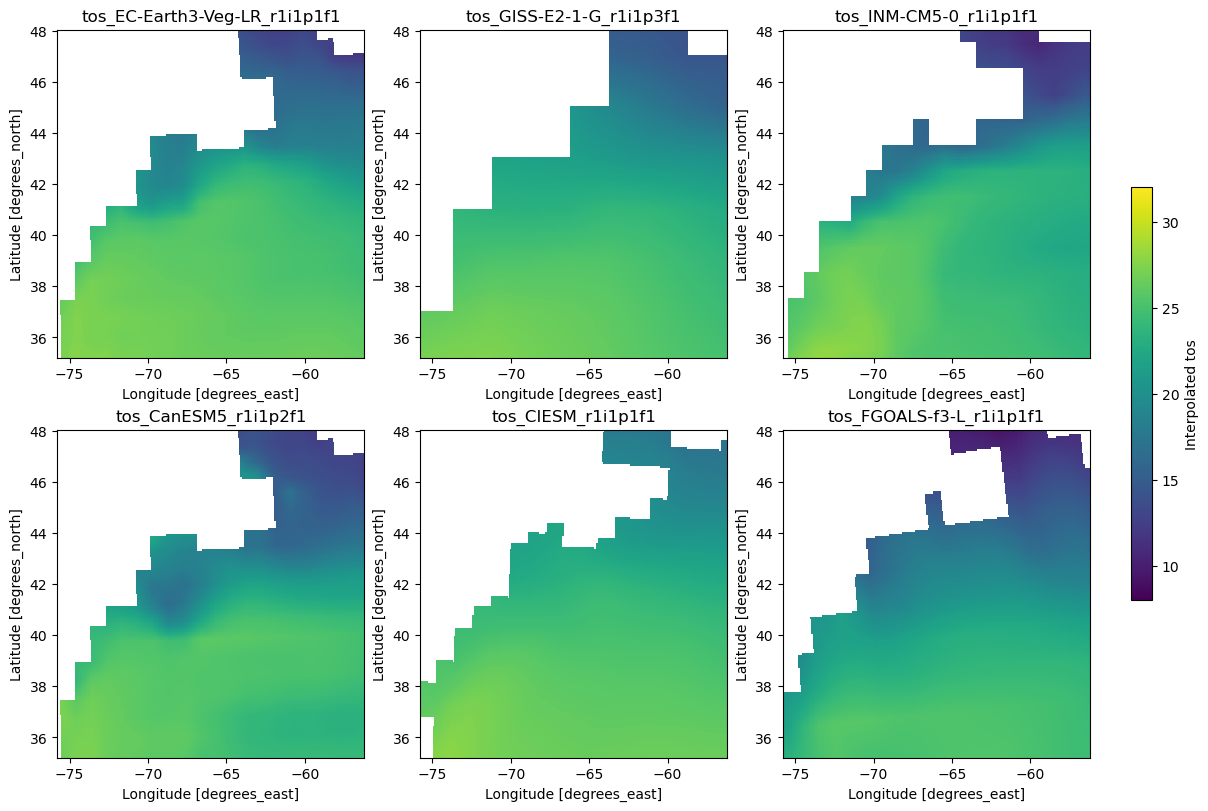

In [10]:
# Select datasets to plot
keys_to_plot = [
    "tos_EC-Earth3-Veg-LR_r1i1p1f1", "tos_GISS-E2-1-G_r1i1p3f1", "tos_INM-CM5-0_r1i1p1f1", 
    "tos_CanESM5_r1i1p2f1", "tos_CIESM_r1i1p1f1", "tos_FGOALS-f3-L_r1i1p1f1"]
datasets_to_plot = [regrid_ds[key] for key in keys_to_plot]

# Create a 3x2 grid for plotting
fig, axes = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each dataset in its corresponding subplot
for i, (data, ax) in enumerate(zip(datasets_to_plot, axes)):
    
    # Assuming time indexing, you might need to select a specific time index here:
    data = data.isel(time = 20)
    
    im = data[cmip_var].plot(ax=ax, vmin = 8, vmax = 32, add_colorbar=False)
    ax.set_title(f"{keys_to_plot[i]}")  # Add title for clarity

# Add a single shared colorbar
cbar = fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.04)
cbar.set_label(f"Interpolated {cmip_var}")

# Hide any unused axes if datasets < grid size
for ax in axes[len(datasets_to_plot):]:
    ax.axis("off")

# Show the plot
plt.show()

In [11]:

# # This is an attempt to strip out the important information and throw it into a new array using its lat/lon coords:

# # Can we flatten/reconstruct from here?
# def simplify_grid(xr_ds, time_var = "time", var = "thetao"):

#     # Convert to nominal x, y indexing
#     # Only perform if its an irregular grid situation
#     is_irregular = xr_ds["lon"].ndim == 2
#     if(is_irregular):
#         xr_ds = replace_x_y_nominal_lat_lon(xr_ds)

#     # Take the data values out as an array
#     data = xr_ds[var].values 
    
#     # Pull the coordinates
#     time      = xr_ds.coords[time_var]
#     longitude = xr_ds.coords['x'] - 360 # because we know glorys is -180 to 180
#     latitude  = xr_ds.coords['y']

#     # Building an xr.array
#     xr_manual = xr.DataArray(data, coords = [time, latitude, longitude]).rename({"x": "longitude", "y" : "latitude"})
#     return xr_manual

# ------------------


# # The following chunk is just for identifying the irregular grids
# # Multi-Index checking

# # If multi-index, replace x,y nominal
# # Check if its a multiIndex / irregular grid situation
# for id, dataset in concatenated_datasets.items():
#     print(f"Checking: {id}")
#     is_irregular = dataset["lon"].ndim == 2
#     print(is_irregular)

# # # This one was True above - works
# # replace_x_y_nominal_lat_lon(concatenated_datasets["tos_EC-Earth3-Veg-LR_r1i1p1f1"])

# # # This one was false above - fails
# # replace_x_y_nominal_lat_lon(concatenated_datasets["tos_MRI-ESM2-0_r1i1p1f1"])



#--------------------

# # The following code is for interpolating using xarray, does not work for all

# # Process all matched files
# interp_datasets = {}
# for key, concat_ds in concatenated_datasets.items():
    
#     # # Convert to nominal x, y indexing
#     # concat_ds = replace_x_y_nominal_lat_lon(concat_ds)
#     simple_ds = simplify_grid(concat_ds, var = cmip_var)

#     # Interpolate
#     interp_datasets[key] = simple_ds.interp(
#         latitude = glorys_clim.latitude,   # Match latitude
#         longitude = glorys_clim.longitude  # Match longitude
#     )


## Process Climatologies for the Reference Period

Each pair (historic + projection) will get its own monthly climatology. This is used to compare against the observation dataset (GLORYs) to determine biases.

In [12]:
# Build historical climatologies
monthly_clims = {}
for key, concat_ds in regrid_ds.items():
    
    # Slice to climatology period
    clim_ds = concat_ds.sel(time=slice(f"{clim_min}-01-01", f"{clim_max}-12-30"))
    clim_ds = clim_ds.groupby("time.month").mean(dim = "time")
    
    # Get monthly means
    print(f"Processing Climatology for: {key}")
    monthly_clims[key] = clim_ds

#monthly_clims['tos_NESM3_r1i1p1f1']


Processing Climatology for: tos_EC-Earth3-Veg-LR_r1i1p1f1
Processing Climatology for: tos_MIROC6_r1i1p1f1
Processing Climatology for: tos_NorESM2-LM_r1i1p1f1
Processing Climatology for: tos_EC-Earth3-Veg_r1i1p1f1
Processing Climatology for: tos_IPSL-CM6A-LR_r1i1p1f1
Processing Climatology for: tos_CMCC-CM2-SR5_r1i1p1f1
Processing Climatology for: tos_FGOALS-g3_r1i1p1f1
Processing Climatology for: tos_GISS-E2-1-G_r1i1p3f1
Processing Climatology for: tos_CESM2-WACCM_r1i1p1f1
Processing Climatology for: tos_NESM3_r1i1p1f1
Processing Climatology for: tos_CNRM-ESM2-1_r4i1p1f2
Processing Climatology for: tos_HadGEM3-GC31-LL_r1i1p1f3
Processing Climatology for: tos_EC-Earth3_r1i1p1f1
Processing Climatology for: tos_GFDL-CM4_r1i1p1f1
Processing Climatology for: tos_CIESM_r1i1p1f1
Processing Climatology for: tos_INM-CM4-8_r1i1p1f1
Processing Climatology for: tos_CanESM5_r1i1p2f1
Processing Climatology for: tos_CNRM-CM6-1_r1i1p1f2
Processing Climatology for: tos_INM-CM5-0_r1i1p1f1
Processing Cli

# Get Monthly Biases


In [13]:
# # Test with one month:
ds1      = monthly_clims['tos_NESM3_r1i1p1f1'] # Original Grid
ds1_simp = simplify_grid(xr_ds = ds1,  time_var = "month", var = "tos") # Simplified structure
ds2      = glorys_clim.rename({var_choice : cmip_var})#.rename({"longitude" : "x", "latitude" : "y"})

# So Recapping here:
# After the regrid, we have common lat/lon names and can get biases this way:
# Which is cleaner
test_diff = ds1[cmip_var] - ds2[cmip_var]
test_diff.isel(month = 0).plot()

# # What if we don't subset the variable
# test_diff = ds1 - ds2

# # works either way
# test_diff.isel(month = 0).tos.plot()

# # We can also simplify them first, but its not necessary
# simp_diff = ds1_simp - ds2[cmip_var].rename()
# simp_diff.isel(month = 0).plot()

NameError: name 'simplify_grid' is not defined

In [14]:
# Build Monthly Climatological Biases
monthly_biases = {}
for key, clim_ds in monthly_clims.items():
    
    # Match the months, get the difference
    bias_ds = clim_ds[cmip_var] - glorys_clim.rename({var_choice : cmip_var})[cmip_var]
    bias_ds = bias_ds.to_dataset(name = cmip_var)
    # 
    print(f"Processing Monthly Biases for: {key}")
    monthly_biases[key] = bias_ds

Processing Monthly Biases for: tos_EC-Earth3-Veg-LR_r1i1p1f1
Processing Monthly Biases for: tos_MIROC6_r1i1p1f1
Processing Monthly Biases for: tos_NorESM2-LM_r1i1p1f1
Processing Monthly Biases for: tos_EC-Earth3-Veg_r1i1p1f1
Processing Monthly Biases for: tos_IPSL-CM6A-LR_r1i1p1f1
Processing Monthly Biases for: tos_CMCC-CM2-SR5_r1i1p1f1
Processing Monthly Biases for: tos_FGOALS-g3_r1i1p1f1
Processing Monthly Biases for: tos_GISS-E2-1-G_r1i1p3f1
Processing Monthly Biases for: tos_CESM2-WACCM_r1i1p1f1
Processing Monthly Biases for: tos_NESM3_r1i1p1f1
Processing Monthly Biases for: tos_CNRM-ESM2-1_r4i1p1f2
Processing Monthly Biases for: tos_HadGEM3-GC31-LL_r1i1p1f3
Processing Monthly Biases for: tos_EC-Earth3_r1i1p1f1
Processing Monthly Biases for: tos_GFDL-CM4_r1i1p1f1
Processing Monthly Biases for: tos_CIESM_r1i1p1f1
Processing Monthly Biases for: tos_INM-CM4-8_r1i1p1f1
Processing Monthly Biases for: tos_CanESM5_r1i1p2f1
Processing Monthly Biases for: tos_CNRM-CM6-1_r1i1p1f2
Processing 

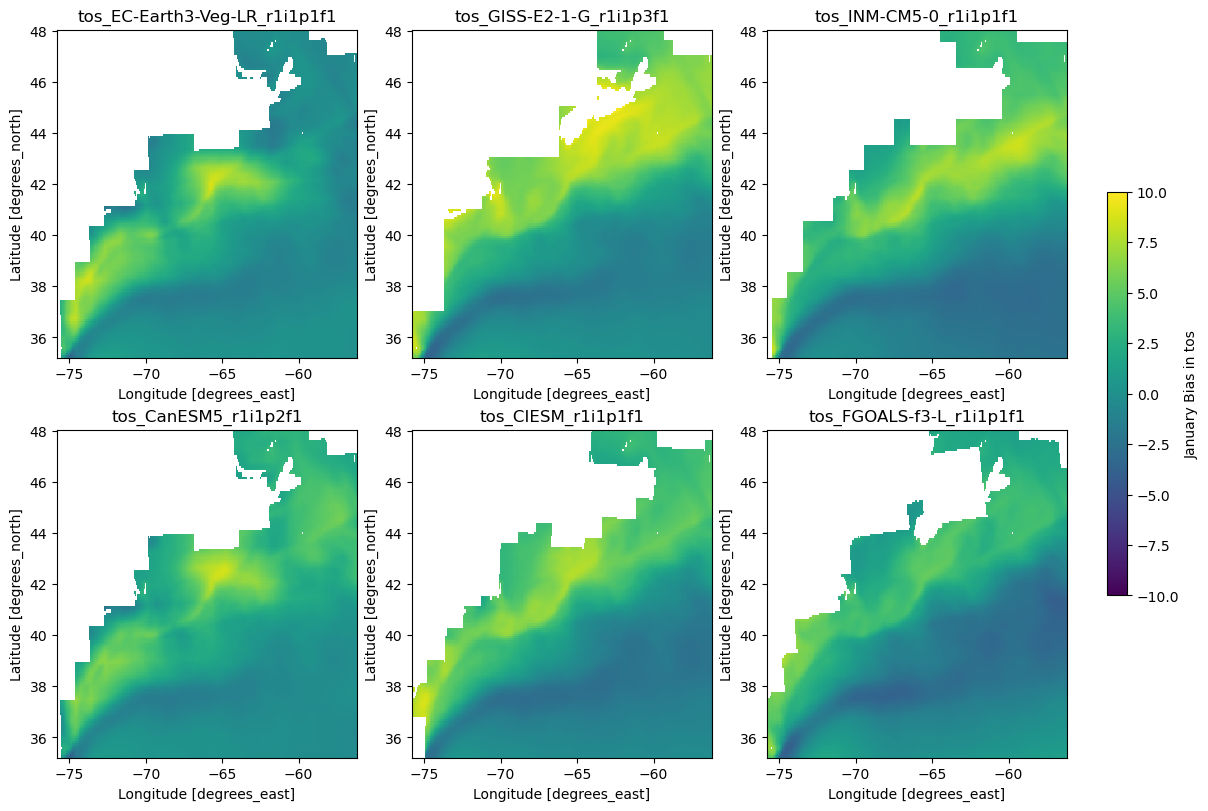

In [15]:

# Select datasets to plot
keys_to_plot = [
    "tos_EC-Earth3-Veg-LR_r1i1p1f1", "tos_GISS-E2-1-G_r1i1p3f1", "tos_INM-CM5-0_r1i1p1f1", 
    "tos_CanESM5_r1i1p2f1", "tos_CIESM_r1i1p1f1", "tos_FGOALS-f3-L_r1i1p1f1"]
datasets_to_plot = [monthly_biases[key] for key in keys_to_plot]

# Create a 3x2 grid for plotting
fig, axes = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each dataset in its corresponding subplot
for i, (data, ax) in enumerate(zip(datasets_to_plot, axes)):
    
    # Assuming time indexing, you might need to select a specific time index here:
    data = data.isel(month = 0)
    
    im = data[cmip_var].plot(ax=ax, vmin = -10, vmax = 10, add_colorbar=False)
    ax.set_title(f"{keys_to_plot[i]}")  # Add title for clarity

# Add a single shared colorbar
cbar = fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.04)
cbar.set_label(f"January Bias in {cmip_var}")

# Hide any unused axes if datasets < grid size
for ax in axes[len(datasets_to_plot):]:
    ax.axis("off")

# Show the plot
plt.show()

# Bias Correct Monthly Scenario Data

We can rejoin the bases, or match them as we go, but these biases are now ready to be used for bias correcting each of the datasets. 

In [16]:
# Remove Biases
corrected_ds = {}
for key, concat_ds in regrid_ds.items():

    # Get the right biases using the key
    print(f"Adjusting Biases for: {key}")
    ds1 = concat_ds
    ds2 = monthly_biases[key]

    # # Group the dataset by month
    # monthly_ds = concat_ds.groupby("time.month")

    # Step 1: Extract month from ds1
    ds1["month"] = ds1["time"].dt.month

    # Step 2: Align ds1 with ds2 by broadcasting
    aligned_ds2 = ds2.sel(month = ds1["month"])

    # Step 3: Perform the subtraction to correct bias
    result = ds1[cmip_var] - aligned_ds2[cmip_var]

    # Final result as a new dataset
    #result_ds = xr.Dataset({"difference": ("time", result)}, coords={"time": ds1["time"]})
    corrected_ds[key] = result.to_dataset(name = f"bias_corrected_{cmip_var}")

    


Adjusting Biases for: tos_EC-Earth3-Veg-LR_r1i1p1f1
Adjusting Biases for: tos_MIROC6_r1i1p1f1
Adjusting Biases for: tos_NorESM2-LM_r1i1p1f1
Adjusting Biases for: tos_EC-Earth3-Veg_r1i1p1f1
Adjusting Biases for: tos_IPSL-CM6A-LR_r1i1p1f1
Adjusting Biases for: tos_CMCC-CM2-SR5_r1i1p1f1
Adjusting Biases for: tos_FGOALS-g3_r1i1p1f1
Adjusting Biases for: tos_GISS-E2-1-G_r1i1p3f1
Adjusting Biases for: tos_CESM2-WACCM_r1i1p1f1
Adjusting Biases for: tos_NESM3_r1i1p1f1
Adjusting Biases for: tos_CNRM-ESM2-1_r4i1p1f2
Adjusting Biases for: tos_HadGEM3-GC31-LL_r1i1p1f3
Adjusting Biases for: tos_EC-Earth3_r1i1p1f1
Adjusting Biases for: tos_GFDL-CM4_r1i1p1f1
Adjusting Biases for: tos_CIESM_r1i1p1f1
Adjusting Biases for: tos_INM-CM4-8_r1i1p1f1
Adjusting Biases for: tos_CanESM5_r1i1p2f1
Adjusting Biases for: tos_CNRM-CM6-1_r1i1p1f2
Adjusting Biases for: tos_INM-CM5-0_r1i1p1f1
Adjusting Biases for: tos_CanESM5-CanOE_r1i1p2f1
Adjusting Biases for: tos_NorESM2-MM_r1i1p1f1
Adjusting Biases for: tos_UKESM1-

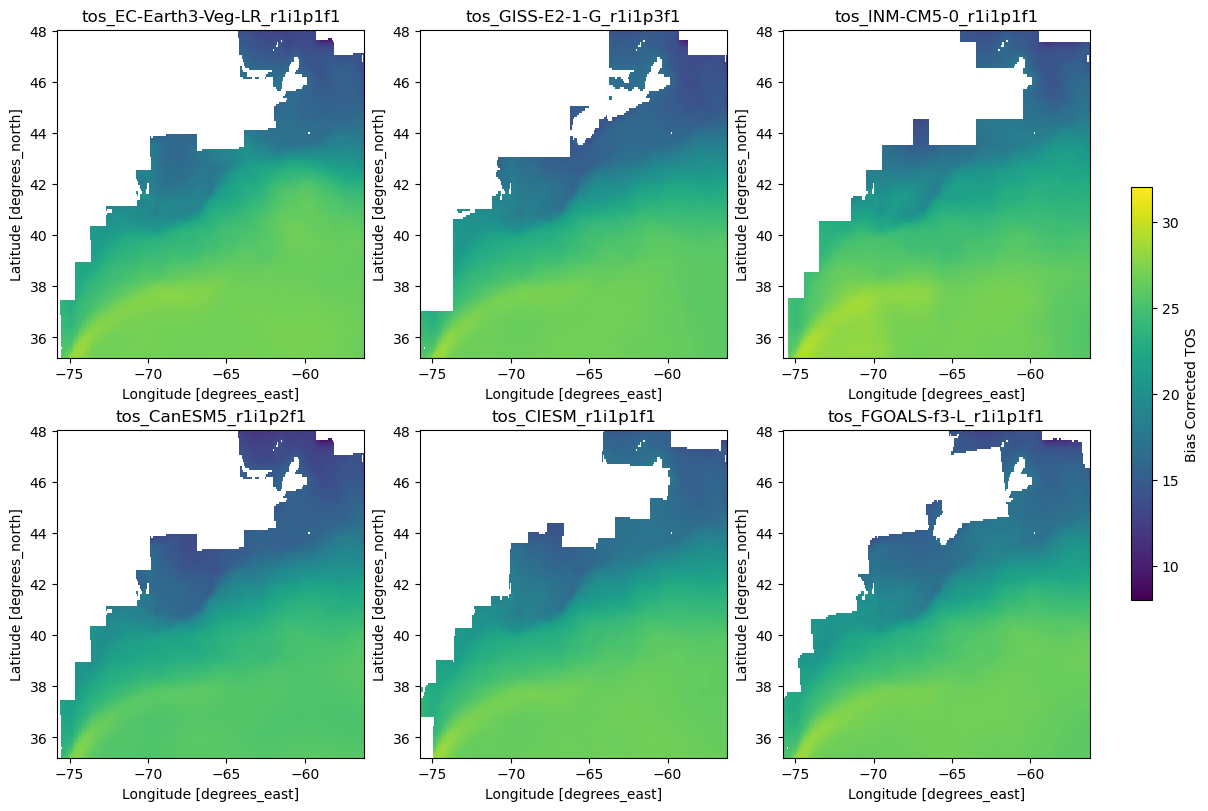

In [17]:
# Select datasets to plot
keys_to_plot = [
    "tos_EC-Earth3-Veg-LR_r1i1p1f1", "tos_GISS-E2-1-G_r1i1p3f1", "tos_INM-CM5-0_r1i1p1f1", 
    "tos_CanESM5_r1i1p2f1", "tos_CIESM_r1i1p1f1", "tos_FGOALS-f3-L_r1i1p1f1"]
datasets_to_plot = [corrected_ds[key] for key in keys_to_plot]

# Create a 3x2 grid for plotting
fig, axes = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each dataset in its corresponding subplot
for i, (data, ax) in enumerate(zip(datasets_to_plot, axes)):
    
    # Assuming time indexing, you might need to select a specific time index here:
    data = data.isel(time = 20)
    
    im = data.bias_corrected_tos.plot(ax=ax, vmin = 8, vmax = 32, add_colorbar=False)
    ax.set_title(f"{keys_to_plot[i]}")  # Add title for clarity

# Add a single shared colorbar
cbar = fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.04)
cbar.set_label("Bias Corrected TOS")

# Hide any unused axes if datasets < grid size
for ax in axes[len(datasets_to_plot):]:
    ax.axis("off")

# Show the plot
plt.show()